In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
import numpy as np

def circular_mean(phases_deg):
    """
    Calculate the circular mean of a list of phase angles (in degrees).
    
    Parameters:
    phases_deg (list or np.ndarray): Array of phase angles in degrees.
    
    Returns:
    float: Circular mean phase in degrees.
    """
    # Convert degrees to radians
    phases_rad = np.deg2rad(phases_deg)
    
    # Compute mean of sines and cosines
    sin_sum = np.sum(np.sin(phases_rad))
    cos_sum = np.sum(np.cos(phases_rad))
    
    # Calculate mean direction using arctangent
    mean_rad = np.arctan2(sin_sum, cos_sum)
    
    # Convert back to degrees
    mean_deg = np.rad2deg(mean_rad)
    
    # Ensure the result is in [0, 360)
    mean_deg = mean_deg % 360
    
    return mean_deg

In [31]:
# 假设你的数据是一个Series
#df_good = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements.pkl')
mean_phase = []
df_good = pd.read_pickle(r'Q:/sachuriga/CR_CA1_paper/tables/functional_properties_with_python_measurements_pycirc.pkl')
for phases_deg in df_good['spike_phase']:
    temp=[]
    temp = circular_mean(phases_deg)
    mean_phase.append(temp) 

df_good['mean_phase']=None
df_good['mean_phase']=mean_phase

df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal')&(df_good['session']=='A')]
df = df_py
base_folder = r"Q:/sachuriga/CR_CA1_paper/Results/functional_cell_type"
control_ids = ['65165', '65091', '63383', '66539', '65622']
exp_ids = ['65588', '63385', '66538', '66537', '66922']
sessions=['A']
for session in sessions:
    # Filter for sessions
    if session == "Total":
        df_a = df
    else:
        df_a = df[df['session'] == session]

    # Separate into control and experimental groups
    control_df = df_a[df_a['animal_id'].isin(control_ids)]
    exp_df = df_a[df_a['animal_id'].isin(exp_ids)]


df_con_deep = control_df[control_df['sub_population']=="deep"].reset_index(drop=True)
df_con_superficial = control_df[control_df['sub_population']=="superficial"].reset_index(drop=True)
df_exp_deep = exp_df[exp_df['sub_population']=="deep"].reset_index(drop=True)
df_exp_superficial = exp_df[exp_df['sub_population']=="superficial"].reset_index(drop=True)

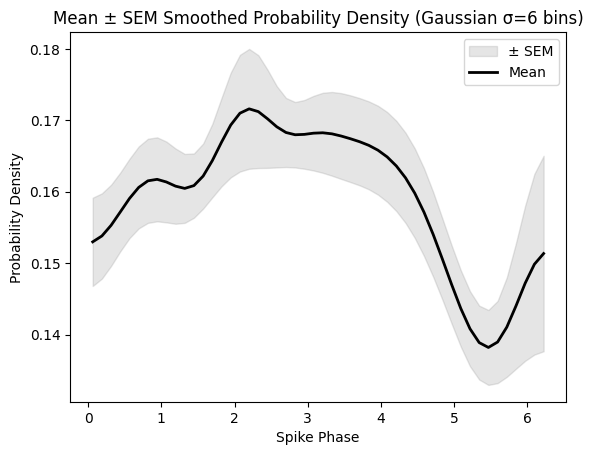

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df=df_con_deep
# Concatenate all data to find global min/max for consistent bins
all_data = np.concatenate(df['spike_phase'].values)
min_val = np.min(all_data)
max_val = np.max(all_data)
bins = np.linspace(min_val, max_val, 51)  # 51 edges for 50 bins

# Compute smoothed densities for each entry
densities = []
sigma = 3  # Gaussian sigma in bin units
for ca in df['spike_phase']:
    hist, _ = np.histogram(ca, bins=bins, density=True)
    smoothed_hist = gaussian_filter1d(hist, sigma=sigma)
    densities.append(smoothed_hist)

densities = np.array(densities)  # Shape: (num_entries, num_bins)

# Calculate mean and SEM across entries
mean_density = np.mean(densities, axis=0)
sem_density = np.std(densities, axis=0) / np.sqrt(densities.shape[0])

# Clip lower bound to 0
lower = np.maximum(mean_density - sem_density, 0)
upper = mean_density + sem_density

# Plot: line for mean (since smoothed), filled for ± SEM
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.fill_between(bin_centers, lower, upper, alpha=0.2, color='gray', label='± SEM')
plt.plot(bin_centers, mean_density, color='black', linewidth=2, label='Mean')

plt.xlabel('Spike Phase')
plt.ylabel('Probability Density')
plt.title('Mean ± SEM Smoothed Probability Density (Gaussian σ=6 bins)')
plt.legend()
plt.show()

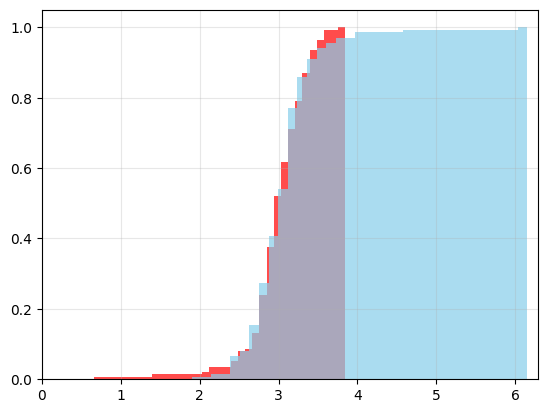

In [46]:
plt.hist(df_exp_deep['mean_phase'],bins=35, density=True, alpha=0.7, color='red',cumulative = True)
plt.hist(df_con_deep['mean_phase'],bins=35, density=True, alpha=0.7, color='skyblue',cumulative = True)
plt.xlim(0, 2 * np.pi)  # Limit x-axis to [0, 2π]
plt.grid(True, alpha=0.3)

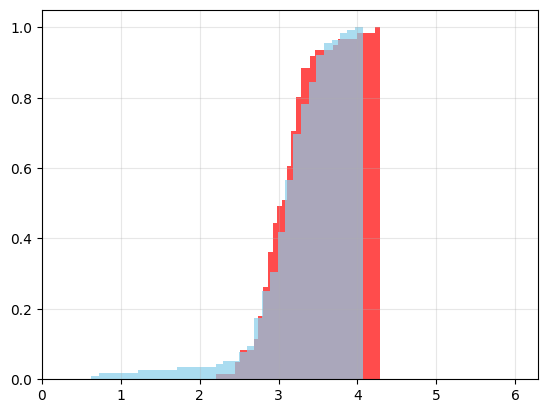

In [47]:
plt.hist(df_exp_superficial['mean_phase'],bins=35, density=True, alpha=0.7, color='red',cumulative = True)
plt.hist(df_con_superficial['mean_phase'],bins=35, density=True, alpha=0.7, color='skyblue',cumulative = True)
plt.xlim(0, 2 * np.pi)  # Limit x-axis to [0, 2π]
plt.grid(True, alpha=0.3)

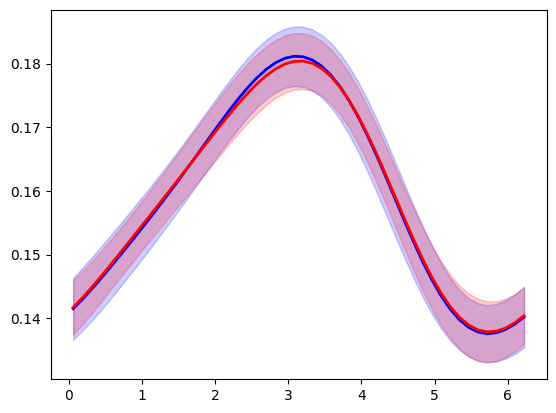

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


#df = df_exp_superficial[(df_exp_superficial["PS_p1"] < 0.05) & (df_exp_superficial["PS_slope1"] < -0.1)]

#df = df_exp_deep[(df_exp_deep["PS_p1"] < 0.05)]
df = control_df

# Concatenate all data to find global min/max for consistent bins
all_data = np.concatenate(df['spike_phase'].values)
min_val = np.min(all_data)
max_val = np.max(all_data)
bins = np.linspace(min_val, max_val, 51)  # 51 edges for 50 bins

# Compute circularly smoothed densities for each entry
densities = []
sigma = 6 # Gaussian sigma in bin units
pad = int(4 * sigma) + 1  # Padding to handle circular wrapping without edge effects
num_bins = len(bins) - 1
for ca in df['spike_phase']:
    hist, _ = np.histogram(ca, bins=bins, density=True)
    padded_hist = np.concatenate((hist[-pad:], hist, hist[:pad]))
    smoothed_padded = gaussian_filter1d(padded_hist, sigma=sigma)
    smoothed_hist = smoothed_padded[pad:pad + num_bins]
    densities.append(smoothed_hist)

densities = np.array(densities)  # Shape: (num_entries, num_bins)

# Calculate mean and SEM across entries
mean_density = np.mean(densities, axis=0)
sem_density = np.std(densities, axis=0) / np.sqrt(densities.shape[0])

# Clip lower bound to 0
lower = np.maximum(mean_density - sem_density, 0)
upper = mean_density + sem_density

# Plot: line for mean (since smoothed), filled for ± SEM
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.fill_between(bin_centers, lower, upper, alpha=0.2, color='blue', label='± SEM')
plt.plot(bin_centers, mean_density, color='blue', linewidth=2, label='Mean')

#df = df_exp_deep[(df_exp_deep["PS_p1"] < 0.05)]
df = exp_df

# Concatenate all data to find global min/max for consistent bins
all_data = np.concatenate(df['spike_phase'].values)
min_val = np.min(all_data)
max_val = np.max(all_data)
bins = np.linspace(min_val, max_val, 51)  # 51 edges for 50 bins

# Compute circularly smoothed densities for each entry
densities = []
sigma = 6  # Gaussian sigma in bin units
pad = int(4 * sigma) + 1  # Padding to handle circular wrapping without edge effects
num_bins = len(bins) - 1
for ca in df['spike_phase']:
    hist, _ = np.histogram(ca, bins=bins, density=True)
    padded_hist = np.concatenate((hist[-pad:], hist, hist[:pad]))
    smoothed_padded = gaussian_filter1d(padded_hist, sigma=sigma)
    smoothed_hist = smoothed_padded[pad:pad + num_bins]
    densities.append(smoothed_hist)

densities = np.array(densities)  # Shape: (num_entries, num_bins)

# Calculate mean and SEM across entries
mean_density = np.mean(densities, axis=0)
sem_density = np.std(densities, axis=0) / np.sqrt(densities.shape[0])

# Clip lower bound to 0
lower = np.maximum(mean_density - sem_density, 0)
upper = mean_density + sem_density

# Plot: line for mean (since smoothed), filled for ± SEM
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.fill_between(bin_centers, lower, upper, alpha=0.2, color='red', label='± SEM')
plt.plot(bin_centers, mean_density, color='red', linewidth=2, label='Mean')
plt.show()

In [19]:
len(control_df)

113

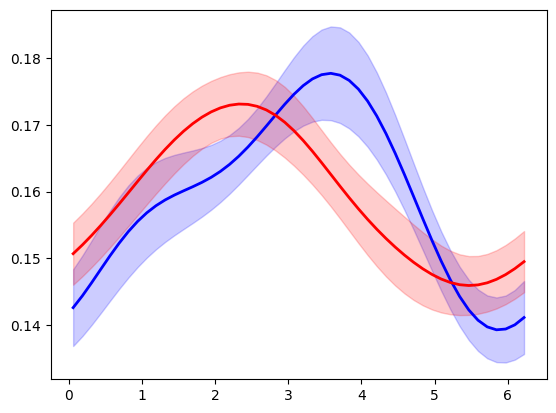

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


#df = df_exp_superficial[(df_exp_superficial["PS_p1"] < 0.05) & (df_exp_superficial["PS_slope1"] < -0.1)]

#df = df_exp_deep[(df_exp_deep["PS_p1"] < 0.05)]
df = df_con_superficial

# Concatenate all data to find global min/max for consistent bins
all_data = np.concatenate(df['spike_phase'].values)
min_val = np.min(all_data)
max_val = np.max(all_data)
bins = np.linspace(min_val, max_val, 51)  # 51 edges for 50 bins

# Compute circularly smoothed densities for each entry
densities = []
sigma = 6 # Gaussian sigma in bin units
pad = int(4 * sigma) + 1  # Padding to handle circular wrapping without edge effects
num_bins = len(bins) - 1
for ca in df['spike_phase']:
    hist, _ = np.histogram(ca, bins=bins, density=True)
    padded_hist = np.concatenate((hist[-pad:], hist, hist[:pad]))
    smoothed_padded = gaussian_filter1d(padded_hist, sigma=sigma)
    smoothed_hist = smoothed_padded[pad:pad + num_bins]
    densities.append(smoothed_hist)

densities = np.array(densities)  # Shape: (num_entries, num_bins)

# Calculate mean and SEM across entries
mean_density = np.mean(densities, axis=0)
sem_density = np.std(densities, axis=0) / np.sqrt(densities.shape[0])

# Clip lower bound to 0
lower = np.maximum(mean_density - sem_density, 0)
upper = mean_density + sem_density

# Plot: line for mean (since smoothed), filled for ± SEM
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.fill_between(bin_centers, lower, upper, alpha=0.2, color='blue', label='± SEM')
plt.plot(bin_centers, mean_density, color='blue', linewidth=2, label='Mean')



#df = df_exp_deep[(df_exp_deep["PS_p1"] < 0.05)]
df = df_exp_superficial

# Concatenate all data to find global min/max for consistent bins
all_data = np.concatenate(df['spike_phase'].values)
min_val = np.min(all_data)
max_val = np.max(all_data)
bins = np.linspace(min_val, max_val, 51)  # 51 edges for 50 bins

# Compute circularly smoothed densities for each entry
densities = []
sigma = 6  # Gaussian sigma in bin units
pad = int(4 * sigma) + 1  # Padding to handle circular wrapping without edge effects
num_bins = len(bins) - 1
for ca in df['spike_phase']:
    hist, _ = np.histogram(ca, bins=bins, density=True)
    padded_hist = np.concatenate((hist[-pad:], hist, hist[:pad]))
    smoothed_padded = gaussian_filter1d(padded_hist, sigma=sigma)
    smoothed_hist = smoothed_padded[pad:pad + num_bins]
    densities.append(smoothed_hist)

densities = np.array(densities)  # Shape: (num_entries, num_bins)

# Calculate mean and SEM across entries
mean_density = np.mean(densities, axis=0)
sem_density = np.std(densities, axis=0) / np.sqrt(densities.shape[0])

# Clip lower bound to 0
lower = np.maximum(mean_density - sem_density, 0)
upper = mean_density + sem_density

# Plot: line for mean (since smoothed), filled for ± SEM
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.fill_between(bin_centers, lower, upper, alpha=0.2, color='red', label='± SEM')
plt.plot(bin_centers, mean_density, color='red', linewidth=2, label='Mean')
plt.show()